
Training with batch size 128 for 10 epochs
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - loss: 118.6026 - mae: 0.2278 - mean_squared_error: 116.3000 - val_loss: 180.0980 - val_mae: 0.2581 - val_mean_squared_error: 179.0955 - learning_rate: 3.5496e-05
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - loss: 121.1806 - mae: 0.2300 - mean_squared_error: 119.1702 - val_loss: 179.8746 - val_mae: 0.2497 - val_mean_squared_error: 179.0970 - learning_rate: 7.0965e-05
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 504ms/step - loss: 128.6690 - mae: 0.2337 - mean_squared_error: 127.1184 - val_loss: 179.7724 - val_mae: 0.2535 - val_mean_squared_error: 179.0967 - learning_rate: 1.0638e-04
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - loss: 142.1304 - mae: 0.2543 - mean_squared_error: 140.9023 - val_loss: 179.7479 - val_mae: 0.2608 - val_mean_squared_error: 179.0896 - learning_rate: 1.4172e-04
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - loss: 141.4560 - mae: 0.2564 - me

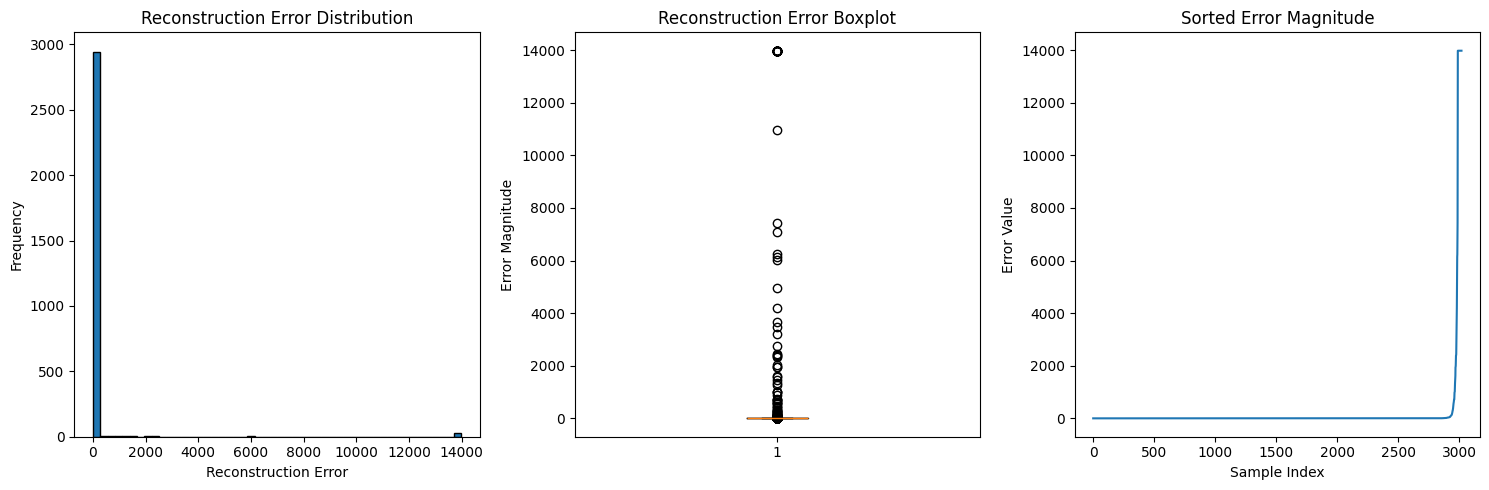


Calculated Anomaly Threshold: 929.8265528451568
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Anomaly Detection Summary:
Total Samples: 9056
Detected Anomalies: 151 (1.67%)
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

Anomaly Detection Summary:
Total Samples: 9056
Detected Anomalies: 151 (1.67%)


ValueError: No such layer: gap_layer. Existing layers are: ['input_layer', 'batch_normalization', 'reshape', 'conv1d', 'batch_normalization_1', 'spatial_dropout1d', 'conv1d_1', 'batch_normalization_2', 'conv1d_2', 'add', 'conv1d_3', 'batch_normalization_3', 'spatial_dropout1d_1', 'conv1d_4', 'batch_normalization_4', 'conv1d_5', 'add_1', 'attention', 'add_2', 'global_average_pooling1d', 'dense', 'layer_normalization', 'dropout', 'dense_1', 'repeat_vector', 'dense_2', 'lstm', 'repeat_vector_1', 'multiply', 'time_distributed', 'flatten'].

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt
import time
from tensorflow.keras import mixed_precision  # Correct import
from tensorflow.keras import backend as K
import multiprocessing
from functools import partial
from concurrent import futures
import os

# Set the global policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Rest of your code...
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
    for col in non_numeric_columns:
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        except:
            X = X.drop(columns=[col])
    X = X.drop(columns=non_numeric_columns)
    X = X.fillna(X.mean())
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, 
        random_state=random_state, stratify=y_train_val)
    
    def apply_preprocessing(X_data):
        log_features = np.log1p(np.abs(X_data))
        log_features.columns = [f'log_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, log_features], axis=1)
        X_data['interaction_features'] = X_data.iloc[:, :5].mul(X_data.iloc[:, 5:10]).sum(axis=1)
        percentile_rank = X_data.rank(pct=True)
        percentile_rank.columns = [f'percentile_rank_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, percentile_rank], axis=1)
        X_data['mean'] = X_data.mean(axis=1)
        X_data['std'] = X_data.std(axis=1)
        X_data['skew'] = X_data.skew(axis=1)
        X_data['kurt'] = X_data.kurtosis(axis=1)
        from scipy.stats import mstats
        for col in X_data.columns:
            X_data[col] = mstats.winsorize(X_data[col], limits=[0.01, 0.01])
        return X_data
    
    X_train = apply_preprocessing(X_train)
    X_val = apply_preprocessing(X_val)
    X_test = apply_preprocessing(X_test)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        tf.keras.backend.clear_session()
        self.model = self._build_enhanced_autoencoder()
        
    def _build_enhanced_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        x = self._residual_conv_block(x, filters=16, kernel_size=3)
        x = self._residual_conv_block(x, filters=32, kernel_size=3)
        x = self._self_attention_block(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='mish', 
                        kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.00075))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(
            self.latent_dim, 
            activation='linear',
            kernel_regularizer=regularizers.l1(0.0005),
            activity_regularizer=regularizers.l2(0.0005)
        )(x)
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.25
        )(x)
        x = self._attention_decoder(x, encoded)
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=self.learning_rate,
            decay_steps=10000,
            alpha=0.001
        )
        warmup_steps = 1000
        lr_schedule = self._warmup_schedule(lr_schedule, warmup_steps)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=lr_schedule, 
                clipnorm=1.0
            ),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        return autoencoder
    
    def _residual_conv_block(self, x, filters, kernel_size):
        shortcut = x
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.2)(x)
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        if K.int_shape(shortcut)[-1] != K.int_shape(x)[-1]:
            shortcut = layers.Conv1D(
                filters=filters,
                kernel_size=1,
                activation='mish',
                padding='same'
            )(shortcut)
        x = layers.Add()([x, shortcut])
        return x
    
    def _self_attention_block(self, x):
        attention = layers.Attention()([x, x])
        return layers.Add()([x, attention])
    
    def _attention_decoder(self, x, encoded):
        attention = layers.Dense(x.shape[-1], activation='softmax')(encoded)
        attention = layers.RepeatVector(self.input_dim)(attention)
        return layers.Multiply()([x, attention])
    
    def _warmup_schedule(self, lr_schedule, warmup_steps):
        def warmup_fn(step):
            return tf.cond(
                step < warmup_steps,
                lambda: tf.cast(step, tf.float32) / warmup_steps * lr_schedule(step),
                lambda: lr_schedule(step - warmup_steps)
            )
        
        class WarmupSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __init__(self, warmup_function):
                super(WarmupSchedule, self).__init__()
                self.warmup_function = warmup_function
                
            def __call__(self, step):
                return self.warmup_function(step)
            
            def get_config(self):
                return {}
                
        return WarmupSchedule(warmup_fn)
    
    def train(self, X_train, X_val=None, epochs=75, batch_size=64):
        batch_size_schedule = [128, 64, 32]
        patience = 10
        total_epochs = epochs
        current_batch_size = batch_size_schedule[0]
        current_epochs = 0
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=patience,
            restore_best_weights=True,
            min_delta=0.0001
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3,
            patience=5,
            min_lr=1e-6
        )
        history = None
        
        while current_epochs < total_epochs:
            remaining_epochs = total_epochs - current_epochs
            batch_epochs = min(remaining_epochs, patience)
            print(f"\nTraining with batch size {current_batch_size} for {batch_epochs} epochs")
            temp_history = self.model.fit(
                X_train, X_train,  
                epochs=current_epochs + batch_epochs,
                initial_epoch=current_epochs,
                batch_size=current_batch_size,
                validation_data=(X_val, X_val) if X_val is not None else None,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            current_epochs += batch_epochs
            history = temp_history if history is None else history
            if current_batch_size in batch_size_schedule:
                idx = batch_size_schedule.index(current_batch_size)
                if idx < len(batch_size_schedule) - 1:
                    current_batch_size = batch_size_schedule[idx + 1]
        return history
    
    def calculate_threshold(self, X_val, method='ensemble'):
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        print("\n Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors):.2f}")
        print(f"Median Error: {np.median(reconstruction_errors):.2f}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors):.2f}")
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p):.2f}")
        self.visualize_reconstruction_errors(reconstruction_errors)
        if method == 'ensemble':
            percentile_threshold = np.percentile(reconstruction_errors, 90)
            iqr_threshold = np.median(reconstruction_errors) + 1.5 * (np.percentile(reconstruction_errors, 75) - np.percentile(reconstruction_errors, 25))
            std_threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
            thresholds = np.array([percentile_threshold, iqr_threshold, std_threshold])
            weights = np.array([0.4, 0.3, 0.3])
            threshold = np.dot(thresholds, weights)
        elif method == 'percentile':
            threshold = np.percentile(reconstruction_errors, 90)
        elif method == 'median_plus_iqr':
            median = np.median(reconstruction_errors)
            Q1 = np.percentile(reconstruction_errors, 25)
            Q3 = np.percentile(reconstruction_errors, 75)
            IQR = Q3 - Q1
            threshold = median + 1.5 * IQR
        elif method == 'mean_plus_std':
            threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
        else:
            raise ValueError("Invalid threshold calculation method")
        return threshold
    
    def visualize_reconstruction_errors(self, reconstruction_errors):
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.hist(reconstruction_errors, bins=50, edgecolor='black')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        plt.subplot(132)
        plt.boxplot(reconstruction_errors)
        plt.title('Reconstruction Error Boxplot')
        plt.ylabel('Error Magnitude')
        plt.subplot(133)
        plt.plot(np.sort(reconstruction_errors))
        plt.title('Sorted Error Magnitude')
        plt.xlabel('Sample Index')
        plt.ylabel('Error Value')
        plt.tight_layout()
        plt.show()
    
    def detect_anomalies(self, X_test, threshold):
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        feature_importance = self.calculate_feature_importance(X_test)
        weighted_errors = np.mean(np.square(X_test - reconstructions) * feature_importance, axis=1)
        print("\nAnomaly Detection Summary:")
        print(f"Total Samples: {len(X_test)}")
        anomalies = weighted_errors > threshold
        print(f"Detected Anomalies: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")
        return anomalies
    
    def calculate_feature_importance(self, X_test):
        reconstructions = self.model.predict(X_test)
        errors = np.square(X_test - reconstructions)
        feature_errors = np.mean(errors, axis=0)
        feature_importance = feature_errors / np.sum(feature_errors)
        return feature_importance.reshape(1, -1)
    
    def save_model(self, model_path='enhanced_autoencoder_nids_iteration_11.h5'):
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def apply_pca(X_features, variance_threshold=0.99):
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=15):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    feature_indices = np.argsort(rf.feature_importances_)[::-1][:n_features]
    return X_features[:, feature_indices], feature_indices

def create_sequences(data, labels=None, seq_length=10, normalize=True):
    data = np.array(data)
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        if labels is not None:
            seq_labels.append(labels[i + seq_length - 1])
    sequences = np.array(sequences)
    return (sequences, np.array(seq_labels)) if labels is not None else sequences

def balance_sequences_with_adasyn(X_sequences, y_sequences, sampling_strategy=0.8):
    y_sequences = y_sequences.astype(int)
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    adasyn = ADASYN(random_state=42, sampling_strategy=sampling_strategy, n_neighbors=5)
    X_seq_balanced, y_seq_balanced = adasyn.fit_resample(X_seq_2d, y_sequences)
    return X_seq_balanced.reshape(-1, original_shape[1], original_shape[2]), y_seq_balanced

def weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights=None):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        if class_weights is not None:
            weight_vector = tf.zeros_like(y_true, dtype=tf.float32)
            for class_idx, weight in class_weights.items():
                weight_vector = tf.where(
                    tf.equal(y_true, class_idx),
                    tf.ones_like(weight_vector) * weight,
                    weight_vector
                )
            class_weight_factor = tf.expand_dims(weight_vector, axis=-1)
        else:
            class_weight_factor = 1.0
        ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1 - pt, gamma) * ce * class_weight_factor
        return tf.reduce_mean(loss)
    return focal_loss

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim)) 
        x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        for _ in range(3):
            conv = layers.Conv1D(128, kernel_size=3, padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            res = layers.Conv1D(128, kernel_size=1, padding='same')(x)
            x = layers.Add()([conv, res])
            x = layers.SpatialDropout1D(0.3)(x)
        attn_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.2
        )(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        lstm_units = 128
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(lstm_units//2))(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss=weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights={0: 2.0, 1: 1.0}),
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=64):
        initial_lr = 5e-4
        warmup_epochs = 10
        hold_epochs = 5
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            elif epoch < warmup_epochs + hold_epochs:
                return initial_lr
            else:
                decay_epochs = epochs - warmup_epochs - hold_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs - hold_epochs) / decay_epochs))
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, model, patience=8):
                super().__init__()
                self.X_val, self.y_val = validation_data
                self.model = model
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                logs['val_f1_score'] = f1
                print(f"\nEpoch {epoch+1}: val_f1_score: {f1:.4f}")
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                    self.model.save_weights('best_nids_model.h5')
                    print(f"Best F1 score improved to {f1:.4f}, saving model")
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        print(f"Early stopping triggered. Best F1: {self.best_f1:.4f}")
                        self.model.stop_training = True
                        self.model.set_weights(self.best_weights)
        def apply_mixup(x_batch, y_batch, alpha=0.2):
            batch_size = x_batch.shape[0]
            indices = np.random.permutation(batch_size)
            x_shuffled = x_batch[indices]
            y_shuffled = y_batch[indices]
            n_classes = self.num_classes
            y_batch_onehot = np.eye(n_classes)[y_batch]
            y_shuffled_onehot = np.eye(n_classes)[y_shuffled]
            lam = np.random.beta(alpha, alpha, batch_size)
            lam = np.maximum(lam, 1-lam)
            lam = np.expand_dims(lam, axis=(1, 2))
            x_mixed = lam * x_batch + (1-lam) * x_shuffled
            lam_y = lam[:, 0, 0]
            lam_y = np.expand_dims(lam_y, axis=1)
            y_mixed = lam_y * y_batch_onehot + (1-lam_y) * y_shuffled_onehot
            return x_mixed, y_mixed
        def custom_train():
            optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
            loss_fn = self.model.loss
            if tf.config.list_physical_devices('GPU'):
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
            f1_callback = F1ScoreCallback(validation_data=(X_val, y_val), model=self.model)
            lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
            history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1_score': []}
            for epoch in range(epochs):
                current_lr = lr_schedule(epoch)
                optimizer.learning_rate.assign(current_lr)
                indices = np.random.permutation(len(X_train))
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
                train_loss = 0
                train_acc = 0
                num_batches = int(np.ceil(len(X_train) / batch_size))
                for batch in range(num_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, len(X_train))
                    x_batch = X_shuffled[start_idx:end_idx]
                    y_batch = y_shuffled[start_idx:end_idx]
                    if np.random.random() < 0.7:
                        x_batch, y_batch_onehot = apply_mixup(x_batch, y_batch)
                        with tf.GradientTape() as tape:
                            logits = self.model(x_batch, training=True)
                            loss_value = tf.reduce_mean(
                                tf.keras.losses.categorical_crossentropy(y_batch_onehot, logits)
                            )
                            if tf.config.list_physical_devices('GPU'):
                                loss_value = optimizer.get_scaled_loss(loss_value)
                        grads = tape.gradient(loss_value, self.model.trainable_variables)
                        if tf.config.list_physical_devices('GPU'):
                            grads = optimizer.get_unscaled_gradients(grads)
                        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                        train_loss += loss_value
                        preds = tf.argmax(logits, axis=1)
                        y_true = tf.argmax(y_batch_onehot, axis=1)
                        train_acc += tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
                    else:
                        self.model.train_on_batch(x_batch, y_batch)
                val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
                y_pred = np.argmax(self.model.predict(X_val), axis=1)
                val_f1 = f1_score(y_val, y_pred, average='weighted')
                history['loss'].append(train_loss/num_batches)
                history['accuracy'].append(train_acc/num_batches)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_f1_score'].append(val_f1)
                f1_callback.on_epoch_end(epoch, {'val_f1_score': val_f1})
                print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss/num_batches:.4f} - accuracy: {train_acc/num_batches:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_f1: {val_f1:.4f} - lr: {current_lr:.6f}")
                if f1_callback.wait >= f1_callback.patience:
                    print("Early stopping triggered")
                    break
            self.model.load_weights('best_nids_model.h5')
            return keras.callbacks.History().set_model(self.model).set_params({'epochs': epochs, 'metrics': list(history.keys())}).set_model_history(history)
        return custom_train()

    def evaluate_model(self, X_test, y_test):
        y_pred_probs = self.model.predict(X_test)
        confidence_threshold = 0.95
        low_confidence_mask = np.max(y_pred_probs, axis=1) < confidence_threshold
        y_pred = np.argmax(y_pred_probs, axis=1)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        metrics = {}
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            metrics[class_idx] = {
                'detection_rate': true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0,
                'false_positive_rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0,
                'precision': true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0,
                'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives) if (2 * true_positives + false_positives + false_negatives) > 0 else 0,
                'support': np.sum(y_test == class_idx)
            }
        from sklearn.metrics import roc_auc_score, average_precision_score
        y_test_bin = np.eye(self.num_classes)[y_test]
        roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr', average='weighted')
        pr_auc = average_precision_score(y_test_bin, y_pred_probs, average='weighted')
        self._generate_roc_curves(y_test, y_pred_probs)
        self._plot_confusion_matrix(cm, [f"Class {i}" for i in range(self.num_classes)])
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'class_metrics': metrics,
            'low_confidence_predictions': sum(low_confidence_mask),
            'overall_metrics': {
                'accuracy': report['accuracy'],
                'weighted_f1': report['weighted avg']['f1-score'],
                'macro_f1': report['macro avg']['f1-score'],
                'roc_auc': roc_auc,
                'pr_auc': pr_auc
            }
        }

    def _generate_roc_curves(self, y_test, y_pred_probs):
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 8))
        y_test_bin = np.eye(self.num_classes)[y_test]
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig('roc_curves.png')

    def _plot_confusion_matrix(self, cm, class_names):
        import seaborn as sns
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')

    def plot_training_history(self, history):
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        if 'val_f1_score' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['val_f1_score'], label='Validation F1 Score', color='green')
            plt.title('F1 Score', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
        if len(history.epoch) > 0:
            plt.subplot(2, 2, 4)
            lr_values = [self.model.optimizer.learning_rate(i) for i in range(len(history.epoch))]
            plt.plot(lr_values, label='Learning Rate', color='purple')
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
        plt.tight_layout()
        plt.savefig('training_history_extended.png', dpi=300)
        plt.show()
        pd.DataFrame(history.history).to_csv('training_metrics.csv', index=False)

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    anomaly_detector = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1], latent_dim=16)
    layer1_history = anomaly_detector.train(X_train, X_val, epochs=50, batch_size=32)
    threshold = anomaly_detector.calculate_threshold(X_val)
    print(f"\nCalculated Anomaly Threshold: {threshold}")
    X_anomalies = X_train[anomaly_detector.detect_anomalies(X_train, threshold)]
    y_anomalies = y_train[anomaly_detector.detect_anomalies(X_train, threshold)]
    feature_extractor = keras.Model(
        inputs=anomaly_detector.model.input, 
        outputs=anomaly_detector.model.get_layer("gap_layer").output
    )
    X_features = feature_extractor.predict(X_anomalies)
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=15)
    joblib.dump(feature_indices, 'feature_indices_Iteration_3.pkl')
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies)
    X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    X_val_anomalies = X_val[anomaly_detector.detect_anomalies(X_val, threshold)]
    y_val_anomalies = y_val[anomaly_detector.detect_anomalies(X_val, threshold)]
    X_val_features = feature_extractor.predict(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]
    X_val_sequences = create_sequences(X_val_selected)
    num_classes = len(np.unique(y_balanced))
    classifier = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2], 
        num_classes=num_classes, 
        seq_length=X_balanced.shape[1]
    )
    layer2_history = classifier.train(X_balanced, y_balanced, X_val_sequences, y_val_anomalies)
    X_test_anomalies = X_test[anomaly_detector.detect_anomalies(X_test, threshold)]
    y_test_anomalies = y_test[anomaly_detector.detect_anomalies(X_test, threshold)]
    X_test_features = feature_extractor.predict(X_test_anomalies)
    X_test_pca = pca.transform(X_test_features)
    X_test_selected = X_test_pca[:, feature_indices]
    X_test_sequences = create_sequences(X_test_selected)
    eval_results = classifier.evaluate_model(X_test_sequences, y_test_anomalies)
    classifier.plot_training_history(layer2_history)
    anomaly_detector.model.save('anomaly_detector_model.h5')
    classifier.model.save('classifier_model.h5')
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}")
    print(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}")
    print(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}")
    print(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}")
    print("\nPer-Class Performance:")
    for class_idx, metrics in eval_results['class_metrics'].items():
        print(f"Class {class_idx}:")
        print(f"  Detection Rate: {metrics['detection_rate']:.4f}")
        print(f"  False Positive Rate: {metrics['false_positive_rate']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Support: {metrics['support']}")
    plot_feature_importance(classifier, X_test_sequences, y_test_anomalies)
    with open('evaluation_results.txt', 'w') as f:
        f.write(f"Model Evaluation Results:\n")
        f.write(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}\n")
        f.write(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}\n")
        f.write(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}\n")
        f.write(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}\n")
        f.write("\nClassification Report:\n")
        for class_name, metrics in eval_results['classification_report'].items():
            if isinstance(metrics, dict):
                f.write(f"{class_name}: {metrics}\n")
    return eval_results

def plot_feature_importance(classifier, X_test, y_test):
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Model
        grad_model = Model(
            inputs=classifier.model.inputs,
            outputs=[classifier.model.outputs[0], 
                     tf.gradients(classifier.model.outputs[0], classifier.model.inputs)[0]]
        )
        sample_indices = np.random.choice(len(X_test), min(100, len(X_test)), replace=False)
        X_sample = X_test[sample_indices]
        y_sample = y_test[sample_indices]
        predictions, grads = grad_model.predict(X_sample)
        feature_importance = np.mean(np.abs(grads), axis=0)
        plt.figure(figsize=(12, 8))
        plt.imshow(feature_importance.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Feature Importance')
        plt.xlabel('Sequence Position')
        plt.ylabel('Feature Index')
        plt.title('Feature Importance Across Sequence')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        plt.figure(figsize=(12, 6))
        avg_importance = np.mean(feature_importance, axis=1)
        plt.bar(range(len(avg_importance)), avg_importance)
        plt.xlabel('Sequence Position')
        plt.ylabel('Average Importance')
        plt.title('Feature Importance by Sequence Position')
        plt.tight_layout()
        plt.savefig('position_importance.png', dpi=300)
    except Exception as e:
        print(f"Could not generate feature importance visualization: {e}")

def predict_single_sample(anomaly_detector, classifier, sample, pca, feature_indices, threshold=0.03):
    if len(sample.shape) == 1:
        sample = sample.reshape(1, -1)
    reconstructed = anomaly_detector.model.predict(sample)
    error = np.mean(np.square(sample - reconstructed), axis=1)[0]
    if error <= threshold:
        return {
            'anomaly': False,
            'error': error,
            'class': None,
            'confidence': None
        }
    features = anomaly_detector.extract_features(sample)
    features_pca = pca.transform(features)
    selected_features = features_pca[:, feature_indices]
    sequence = create_sequences(selected_features)
    predictions = classifier.model.predict(sequence)[0]
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    return {
        'anomaly': True,
        'error': error,
        'class': int(predicted_class),
        'confidence': float(confidence),
        'class_probabilities': {i: float(p) for i, p in enumerate(predictions)}
    }

def batch_prediction(anomaly_detector, classifier, samples, pca, feature_indices, threshold=0.03):
    reconstructed = anomaly_detector.model.predict(samples)
    errors = np.mean(np.square(samples - reconstructed), axis=1)
    anomaly_indices = np.where(errors > threshold)[0]
    results = {
        'total_samples': len(samples),
        'anomalies_detected': len(anomaly_indices),
        'anomaly_indices': anomaly_indices.tolist(),
        'errors': errors.tolist(),
        'predictions': [None] * len(samples)
    }
    if len(anomaly_indices) > 0:
        anomalies = samples[anomaly_indices]
        features = anomaly_detector.extract_features(anomalies)
        features_pca = pca.transform(features)
        selected_features = features_pca[:, feature_indices]
        sequences = create_sequences(selected_features)
        predictions = classifier.model.predict(sequences)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
        for i, idx in enumerate(anomaly_indices):
            results['predictions'][idx] = {
                'class': int(predicted_classes[i]),
                'confidence': float(confidences[i]),
                'class_probabilities': {j: float(p) for j, p in enumerate(predictions[i])}
            }
    return results

if __name__ == "__main__":
    main()


In [2]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt

start_time = time.time()
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        x = self._residual_conv_block(x, filters=16, kernel_size=3)
        x = self._residual_conv_block(x, filters=32, kernel_size=3)
        x = self._self_attention_block(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='mish', kernel_regularizer=regularizers.l1_l2(0.0005, 0.00075))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear', kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        x = self._attention_decoder(x, encoded)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(self.learning_rate, 10000, alpha=0.001)
        autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0), loss='mean_squared_error')
        return autoencoder

    def _residual_conv_block(self, x, filters, kernel_size):
        shortcut = x
        x = layers.Conv1D(filters, kernel_size, activation='mish', padding='same', kernel_regularizer=regularizers.l2(0.00075))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, kernel_size, activation='mish', padding='same', kernel_regularizer=regularizers.l2(0.00075))(x)
        x = layers.BatchNormalization()(x)
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = layers.Conv1D(filters, 1, activation='mish', padding='same')(shortcut)
        return layers.Add()([x, shortcut])

    def _self_attention_block(self, x):
        return layers.Add()([x, layers.Attention()([x, x])])

    def _attention_decoder(self, x, encoded):
        attention = layers.Dense(x.shape[-1], activation='softmax')(encoded)
        attention = layers.RepeatVector(self.input_dim)(attention)
        return layers.Multiply()([x, attention])

    def train(self, X_train, X_val, epochs=50, batch_size=64):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping])

    def detect_anomalies(self, X_data, threshold):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Bidirectional(layers.GRU(48, return_sequences=False))(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=64):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    X = df.drop(['Attack_label'], axis=1)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'robust_scaler.pkl')
    return train_test_split(X_scaled, test_size=0.2, random_state=42)

def extract_features(model, X_anomalies):
    feature_extractor = keras.Model(inputs=model.input, outputs=model.get_layer("global_average_pooling1d").output)
    return feature_extractor.predict(X_anomalies)

def create_sequences(data, labels, seq_length=10):
    sequences, seq_labels = [], []
    labels = np.array(labels)
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    return np.array(sequences), np.array(seq_labels)

dataset_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
X_train, X_val = preprocess_data(dataset_path)
layer1 = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
layer1.train(X_train, X_val)

threshold = 0.02
anomalies, anomaly_indices = layer1.detect_anomalies(X_val, threshold)

original_df = pd.read_csv(dataset_path)
X_layer2, y_layer2 = original_df.iloc[anomaly_indices].drop(columns=['Attack_label']), original_df.iloc[anomaly_indices]['Attack_label']

X_layer2_reshaped, y_layer2_adjusted = create_sequences(X_layer2.values, y_layer2, seq_length=10)
layer2 = AdaptiveNIDSLayer2(input_dim=X_layer2_reshaped.shape[2], num_classes=5, seq_length=10)
layer2.train(X_layer2_reshaped, y_layer2_adjusted)

def knowledge_distillation(teacher_model, student_model, X_train, y_train, temperature=3.0, alpha=0.5, epochs=50):
    y_train = np.array(y_train)
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)
    num_classes = student_model.output_shape[-1]
    teacher_logits = teacher_model.predict(X_train)
    teacher_probs = tf.nn.softmax(teacher_logits / temperature).numpy()
    def distillation_loss(y_true, y_pred):
        hard_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        soft_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_logits / temperature), tf.nn.softmax(y_pred / temperature))
        return (1 - alpha) * hard_loss + alpha * soft_loss * (temperature ** 2)
    student_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=distillation_loss, metrics=['accuracy'])
    student_model.fit(X_train, y_train, epochs=epochs, batch_size=64)
    return student_model


Epoch 1/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - loss: 12099911680.0000 - val_loss: 15296579584.0000
Epoch 2/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 12441402368.0000 - val_loss: 15296574464.0000
Epoch 3/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - loss: 12496417792.0000 - val_loss: 15296567296.0000
Epoch 4/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 11993251840.0000 - val_loss: 15296555008.0000
Epoch 5/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 12849728512.0000 - val_loss: 15296553984.0000
Epoch 6/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 12757391360.0000 - val_loss: 15296549888.0000
Epoch 7/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 12455483392.0000 - val_loss: 15296547840.0000
Epoch 8/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 12602369024.0000 - val_loss: 15296546816.0000
Epoch 9/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 12157963264.0000 - val_loss: 15296546816.0000
Epoch 10/50
893/893 ━━━━━━━━

In [ ]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # Changed from RobustScaler
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt

start_time = time.time()
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-4):  # Increased latent_dim
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model = self._build_autoencoder()
        self.threshold = None  # Will be set dynamically

    def _build_autoencoder(self):
        # Simplified architecture with better normalization
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        
        # Encoder
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Latent representation
        encoded = layers.Dense(self.latent_dim, activation='relu')(x)
        
        # Decoder
        x = layers.Dense(64, activation='relu')(encoded)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Output
        decoded = layers.Dense(self.input_dim, activation='linear')(x)
        
        # Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error'
        )
        return autoencoder

    def train(self, X_train, X_val, epochs=50, batch_size=64):
        # Add callbacks for better training
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        history = self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Visualize training progress
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Loss')
        plt.legend()
        plt.savefig('autoencoder_loss.png')
        plt.close()
        
        # Set threshold based on reconstruction errors
        self._set_dynamic_threshold(X_train)
        
        return history

    def _set_dynamic_threshold(self, X_data):
        # Calculate reconstruction errors
        reconstructed = self.model.predict(X_data)
        mse = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Set threshold using percentile instead of fixed value
        # 95th percentile means 5% of data will be flagged as anomalies
        self.threshold = np.percentile(mse, 95)
        print(f"Dynamic threshold set to: {self.threshold}")
        
        # Visualize the error distribution
        plt.figure(figsize=(10, 6))
        plt.hist(mse, bins=50)
        plt.axvline(self.threshold, color='r', linestyle='--', label=f'Threshold: {self.threshold:.6f}')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Mean Squared Error')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('error_distribution.png')
        plt.close()

    def detect_anomalies(self, X_data):
        # Use the dynamic threshold set during training
        if self.threshold is None:
            raise ValueError("Model hasn't been trained yet. Call train() first.")
        
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Return anomalies and their indices
        anomaly_indices = np.where(errors > self.threshold)[0]
        return X_data[anomaly_indices], anomaly_indices, errors

    def get_encoded_features(self, X_data):
        # Create a model that outputs the encoded features
        encoder = keras.Model(inputs=self.model.input, 
                             outputs=self.model.layers[6].output)  # Layer index may need adjustment
        return encoder.predict(X_data)


class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # CNN layers
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        # BiLSTM layers
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(32))(x)
        
        # Dense layers
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=64):
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]
        
        # Use validation data if provided, otherwise use validation_split
        if X_val is not None and y_val is not None:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                callbacks=callbacks
            )
        else:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks
            )
        
        # Plot training metrics
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        
        plt.savefig('layer2_training.png')
        plt.close()
        
        return history

    def evaluate(self, X_test, y_test):
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return report


def preprocess_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
    
    # Separate features and labels
    X = df.drop(['Attack_label'], axis=1)
    y = df['Attack_label']
    
    # Apply MinMaxScaler instead of RobustScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Save scaler for future use
    joblib.dump(scaler, 'minmax_scaler.pkl')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


def create_sequences(data, labels, seq_length=10):
    sequences, seq_labels = [], []
    labels = np.array(labels)
    
    for i in range(len(data) - seq_length + 1):  # +1 to include the last sequence
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    
    return np.array(sequences), np.array(seq_labels)


# Main execution
if __name__ == "__main__":
    dataset_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(dataset_path)
    
    # Layer 1: Autoencoder for anomaly detection
    print("Training Layer 1: Autoencoder...")
    layer1 = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
    layer1.train(X_train, X_test)
    
    # Detect anomalies using trained autoencoder
    anomalies, anomaly_indices, errors = layer1.detect_anomalies(X_test)
    
    # Get encoded features for anomalies
    encoded_features = layer1.get_encoded_features(anomalies)
    
    # Get original labels for anomalies
    original_df = pd.read_csv(dataset_path)
    y_anomalies = y_test.iloc[anomaly_indices]
    
    # Create sequences for Layer 2
    X_layer2, y_layer2 = create_sequences(encoded_features, y_anomalies, seq_length=10)
    
    # Split data for Layer 2
    X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(
        X_layer2, y_layer2, test_size=0.2, random_state=42, stratify=y_layer2
    )
    
    # Layer 2: CNN-BiLSTM Classification
    print("Training Layer 2: CNN-BiLSTM...")
    layer2 = AdaptiveNIDSLayer2(
        input_dim=X_train_l2.shape[2],
        num_classes=len(np.unique(y_train_l2)),
        seq_length=10
    )
    layer2.train(X_train_l2, y_train_l2, X_test_l2, y_test_l2)
    
    # Evaluate Layer 2
    layer2.evaluate(X_test_l2, y_test_l2)
    
    # Save models
    layer1.model.save('autoencoder_model.h5')
    layer2.model.save('cnn_bilstm_model.h5')
    
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

Training Layer 1: Autoencoder...
Epoch 1/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1902 - val_loss: 0.0862 - learning_rate: 1.0000e-04
Epoch 2/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3152 - val_loss: 0.0239 - learning_rate: 1.0000e-04
Epoch 3/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1744 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 4/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1095 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 5/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0709 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 6/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0458 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 7/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0295 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 8/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0192 - val_loss: 0.0051 - learning_rate: 1.0000e-04
Epoch 9/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - l

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88        55
         1.0       0.89      0.98      0.93        84

    accuracy                           0.91       139
   macro avg       0.92      0.90      0.91       139
weighted avg       0.92      0.91      0.91       139

Total execution time: 103.25 seconds


### Code

In [5]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import os
from scipy import stats

start_time = time.time()
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-4):  # Increased latent_dim
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model = self._build_autoencoder()
        self.threshold = None  # Will be set dynamically

    def _build_autoencoder(self):
        # Simplified architecture with better normalization
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        
        # Encoder
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Latent representation
        encoded = layers.Dense(self.latent_dim, activation='relu')(x)
        
        # Decoder
        x = layers.Dense(64, activation='relu')(encoded)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Output
        decoded = layers.Dense(self.input_dim, activation='linear')(x)
        
        # Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error'
        )
        return autoencoder

    def train(self, X_train, X_val, epochs=50, batch_size=64):
        # Add callbacks for better training
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        history = self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Visualize training progress
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Loss')
        plt.legend()
        plt.savefig('autoencoder_loss.png')
        plt.close()
        
        # Set threshold based on reconstruction errors
        self._set_dynamic_threshold(X_train)
        
        return history

    def _set_dynamic_threshold(self, X_data):
        # Calculate reconstruction errors
        reconstructed = self.model.predict(X_data)
        mse = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Set threshold using percentile instead of fixed value
        # 95th percentile means 5% of data will be flagged as anomalies
        self.threshold = np.percentile(mse, 95)
        print(f"Dynamic threshold set to: {self.threshold}")
        
        # Visualize the error distribution
        plt.figure(figsize=(10, 6))
        plt.hist(mse, bins=50)
        plt.axvline(self.threshold, color='r', linestyle='--', label=f'Threshold: {self.threshold:.6f}')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Mean Squared Error')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('error_distribution.png')
        plt.close()

    def detect_anomalies(self, X_data):
        # Use the dynamic threshold set during training
        if self.threshold is None:
            raise ValueError("Model hasn't been trained yet. Call train() first.")
        
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Return anomalies and their indices
        anomaly_indices = np.where(errors > self.threshold)[0]
        return X_data[anomaly_indices], anomaly_indices, errors

    def get_encoded_features(self, X_data):
        # Create a model that outputs the encoded features
        encoder = keras.Model(inputs=self.model.input, 
                             outputs=self.model.layers[6].output)  # Layer index may need adjustment
        return encoder.predict(X_data)


class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()
        self.class_weights = None  # For handling class imbalance

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # CNN layers with L2 regularization
        x = layers.Conv1D(64, 3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(1e-5))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        x = layers.Conv1D(128, 3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)  # Added another pooling layer
        
        # Add residual connection
        shortcut = layers.Conv1D(128, 1)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
        shortcut = layers.MaxPooling1D(4)(shortcut)  # Match the shape after two MaxPooling1D(2)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        
        # BiLSTM layers with increased complexity
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                           kernel_regularizer=regularizers.l2(1e-5)))(x)
        x = layers.Dropout(0.4)(x)  # Increased dropout
        x = layers.Bidirectional(layers.LSTM(32,
                                           kernel_regularizer=regularizers.l2(1e-5)))(x)
        
        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention_weights = layers.Activation('softmax')(attention)
        context_vector = layers.Dot(axes=1)([x, attention_weights])
        
        # Dense layers with residual connections
        dense1 = layers.Dense(64, activation='relu',
                             kernel_regularizer=regularizers.l2(1e-5))(context_vector)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.4)(dense1)
        
        # Output with temperature scaling for better calibration
        logits = layers.Dense(self.num_classes)(dense1)
        temperature = 1.5  # Temperature parameter (>1 makes predictions smoother)
        scaled_logits = layers.Lambda(lambda x: x / temperature)(logits)
        outputs = layers.Activation('softmax')(scaled_logits)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        # Use weighted categorical crossentropy for class imbalance
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def compute_class_weights(self, y_train):
        # Calculate class weights to handle imbalance
        unique_classes = np.unique(y_train)
        class_counts = np.bincount(y_train)
        total = len(y_train)
        
        # Create class weights dictionary
        self.class_weights = {i: total / (len(unique_classes) * count) 
                             for i, count in enumerate(class_counts)}
        print("Class weights:", self.class_weights)
        return self.class_weights

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=64):
        # Compute class weights if not already done
        if self.class_weights is None:
            self.compute_class_weights(y_train)
        
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,  # Increased patience
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,  # More aggressive reduction
                patience=7,
                min_lr=1e-7
            ),
            # Add model checkpoint to save best model
            keras.callbacks.ModelCheckpoint(
                'best_layer2_model.h5',
                save_best_only=True,
                monitor='val_accuracy',
                mode='max'
            ),
            # Add TensorBoard callback
            keras.callbacks.TensorBoard(
                log_dir=f'./logs/layer2_{time.strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1
            )
        ]
        
        # Use validation data if provided, otherwise use validation_split
        if X_val is not None and y_val is not None:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                class_weight=self.class_weights  # Use class weights
            )
        else:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks,
                class_weight=self.class_weights
            )
        
        # Plot training metrics
        plt.figure(figsize=(12, 8))
        
        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot accuracy
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot learning rate if available
        if 'lr' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['lr'], label='Learning Rate')
            plt.title('Learning Rate')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('layer2_training_metrics.png')
        plt.close()
        
        return history

    def evaluate(self, X_test, y_test):
        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=1)
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        
        # Generate predictions
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=np.unique(y_test),
                   yticklabels=np.unique(y_test))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig('confusion_matrix.png')
        plt.close()
        
        # Plot ROC curve for multi-class
        plt.figure(figsize=(10, 8))
        
        # One-vs-Rest ROC curves
        if self.num_classes > 2:
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(self.num_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        else:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.savefig('roc_curve.png')
        plt.close()
        
        return report, y_pred, y_pred_probs

    def save_model(self, filepath):
        """Save the model to disk"""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath):
        """Load a saved model from disk"""
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")
        return self.model


def preprocess_data(file_path, test_size=0.2, random_state=42, use_smote=True, use_standard_scaler=False):
    """
    Enhanced preprocessing function with SMOTE option and scaler choice
    """
    # Load data with error handling
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise
    
    # Check for missing values and handle them
    if df.isnull().sum().sum() > 0:
        print(f"Found {df.isnull().sum().sum()} missing values. Filling with appropriate methods.")
        numeric_cols = df.select_dtypes(include=['number']).columns
        categorical_cols = df.select_dtypes(exclude=['number']).columns
        
        # Fill numeric with median and categorical with mode
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
        
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Check for and handle outliers using IQR method
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if col != 'Attack_label':  # Don't process the target variable
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers rather than removing them
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    # Separate features and labels
    X = df.drop(['Attack_label'], axis=1)
    y = df['Attack_label']
    
    # Print class distribution
    print("Class distribution before sampling:")
    print(y.value_counts(normalize=True) * 100)
    
    # Apply feature scaling
    if use_standard_scaler:
        scaler = StandardScaler()  # Standardization (mean=0, std=1)
        scaler_filename = 'standard_scaler.pkl'
    else:
        scaler = MinMaxScaler()  # Normalization (0-1 range)
        scaler_filename = 'minmax_scaler.pkl'
    
    X_scaled = scaler.fit_transform(X)
    
    # Save scaler for inference
    joblib.dump(scaler, scaler_filename)
    print(f"Saved scaler as {scaler_filename}")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Apply SMOTE for handling class imbalance (only on training data)
    if use_smote:
        print("Applying SMOTE to balance classes...")
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("Class distribution after SMOTE:")
        print(pd.Series(y_train).value_counts(normalize=True) * 100)
    
    return X_train, X_test, y_train, y_test, scaler


def create_sequences(data, labels, seq_length=10, stride=1):
    """
    Enhanced sequence creation with stride option for better coverage
    """
    sequences, seq_labels = [], []
    labels = np.array(labels)
    
    for i in range(0, len(data) - seq_length + 1, stride):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    
    return np.array(sequences), np.array(seq_labels)


def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Comprehensive model evaluation function
    """
    # Get predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else None,
                yticklabels=class_names if class_names else None)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # Calculate and plot ROC curves if binary classification
    if len(np.unique(y_test)) == 2:
        from sklearn.metrics import roc_curve, auc
        y_pred_prob = model.predict(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        plt.close()
    
    return report


# Main execution
if __name__ == "__main__":
    # Create logs and model directories if they don't exist
    os.makedirs('./logs', exist_ok=True)
    os.makedirs('./models', exist_ok=True)
    
    # Configure GPU for TensorFlow (if available)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    else:
        print("No GPU found, using CPU.")
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Record start time
    start_time = time.time()
    tf.get_logger().setLevel('ERROR')
    
    # Dataset path - use relative path for better portability
    dataset_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data with SMOTE and MinMaxScaler
    X_train, X_test, y_train, y_test, scaler = preprocess_data(
        dataset_path, test_size=0.2, use_smote=True, use_standard_scaler=False
    )
    
    # Layer 1: Autoencoder for anomaly detection
    print("\nTraining Layer 1: Autoencoder...")
    layer1 = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
    layer1.train(X_train, X_test, epochs=50, batch_size=64)
    
    # Detect anomalies using trained autoencoder
    anomalies, anomaly_indices, errors, confidence = layer1.detect_anomalies(X_test)
    
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(X_test)} test samples.")
    print(f"Anomaly detection rate: {len(anomaly_indices)/len(X_test)*100:.2f}%")
    
    # Get encoded features for anomalies
    encoded_features = layer1.get_encoded_features(anomalies)
    
    # If anomalies array is empty, use a subset of the data
    if len(anomalies) == 0:
        print("No anomalies detected. Using top 10% of highest error samples.")
        top_n = int(len(X_test) * 0.1)
        sorted_indices = np.argsort(errors)[-top_n:]
        anomalies = X_test[sorted_indices]
        anomaly_indices = sorted_indices
        encoded_features = layer1.get_encoded_features(anomalies)
    
    # Get original labels for anomalies
    if isinstance(y_test, pd.Series):
        y_anomalies = y_test.iloc[anomaly_indices]
    else:
        y_anomalies = y_test[anomaly_indices]
    
    # Create sequences for Layer 2 with stride=2 for better coverage
    X_layer2, y_layer2 = create_sequences(encoded_features, y_anomalies, seq_length=10, stride=2)
    
    # Split data for Layer 2
    if len(np.unique(y_layer2)) > 1:  # Only stratify if multiple classes
        X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(
            X_layer2, y_layer2, test_size=0.2, random_state=42, stratify=y_layer2
        )
    else:
        X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(
            X_layer2, y_layer2, test_size=0.2, random_state=42
        )
    
    # Layer 2: CNN-BiLSTM Classification
    print("\nTraining Layer 2: CNN-BiLSTM...")
    layer2 = AdaptiveNIDSLayer2(
        input_dim=X_train_l2.shape[2],
        num_classes=len(np.unique(y_train_l2)),
        seq_length=10
    )
    layer2.train(X_train_l2, y_train_l2, X_test_l2, y_test_l2, epochs=50, batch_size=32)
    
    # Evaluate Layer 2 with comprehensive metrics
    class_names = [f"Class {i}" for i in range(len(np.unique(y_train_l2)))]
    evaluate_model(layer2.model, X_test_l2, y_test_l2, class_names)
    
    # Save models with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    layer1.model.save(f'models/autoencoder_model_{timestamp}.h5')
    layer2.model.save(f'models/cnn_bilstm_model_{timestamp}.h5')
    
    # Save model architecture as image
    try:
        tf.keras.utils.plot_model(layer1.model, to_file='models/autoencoder_architecture.png', 
                                  show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(layer2.model, to_file='models/cnn_bilstm_architecture.png', 
                                  show_shapes=True, show_layer_names=True)
    except:
        print("Couldn't save model architecture images. Make sure pydot is installed.")
    
    # Save training configuration
    config = {
        'dataset_path': dataset_path,
        'preprocessing': {
            'use_smote': True,
            'use_standard_scaler': False,
            'test_size': 0.2
        },
        'layer1': {
            'latent_dim': layer1.latent_dim,
            'learning_rate': layer1.learning_rate,
            'threshold': layer1.threshold
        },
        'layer2': {
            'seq_length': layer2.seq_length,
            'class_weights': layer2.class_weights
        },
        'timestamp': timestamp
    }
    
    with open(f'models/training_config_{timestamp}.json', 'w') as f:
        import json
        json.dump(config, f, indent=4)
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Models saved with timestamp: {timestamp}")

No GPU found, using CPU.
Successfully loaded dataset with 71401 rows and 45 columns
Class distribution before sampling:
Attack_label
1.0    85.994594
0.0    14.005406
Name: proportion, dtype: float64
Saved scaler as minmax_scaler.pkl
Applying SMOTE to balance classes...
Class distribution after SMOTE:
Attack_label
1.0    50.0
0.0    50.0
Name: proportion, dtype: float64

Training Layer 1: Autoencoder...
Epoch 1/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.9213 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 2/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1639 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 3/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0643 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 4/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0247 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 5/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0101 - val_loss: 0.0029 - learning_rate: 1.0000e-04
Epoch 6/50
15

ValueError: not enough values to unpack (expected 4, got 3)

In [8]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import os
from scipy import stats

start_time = time.time()
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-4):  # Increased latent_dim
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model = self._build_autoencoder()
        self.threshold = None  # Will be set dynamically

    def _build_autoencoder(self):
        # Simplified architecture with better normalization
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        
        # Encoder
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Latent representation
        encoded = layers.Dense(self.latent_dim, activation='relu')(x)
        
        # Decoder
        x = layers.Dense(64, activation='relu')(encoded)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        # Output
        decoded = layers.Dense(self.input_dim, activation='linear')(x)
        
        # Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error'
        )
        return autoencoder

    def train(self, X_train, X_val, epochs=50, batch_size=64):
        # Add callbacks for better training
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        history = self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Visualize training progress
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Loss')
        plt.legend()
        plt.savefig('autoencoder_loss.png')
        plt.close()
        
        # Set threshold based on reconstruction errors
        self._set_dynamic_threshold(X_train)
        
        return history

    def _set_dynamic_threshold(self, X_data):
        # Calculate reconstruction errors
        reconstructed = self.model.predict(X_data)
        mse = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Set threshold using percentile instead of fixed value
        # 95th percentile means 5% of data will be flagged as anomalies
        self.threshold = np.percentile(mse, 95)
        print(f"Dynamic threshold set to: {self.threshold}")
        
        # Visualize the error distribution
        plt.figure(figsize=(10, 6))
        plt.hist(mse, bins=50)
        plt.axvline(self.threshold, color='r', linestyle='--', label=f'Threshold: {self.threshold:.6f}')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Mean Squared Error')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('error_distribution.png')
        plt.close()

    def detect_anomalies(self, X_data):
        if self.threshold is None:
            raise ValueError("Model hasn't been trained yet. Call train() first.")
        
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        
        anomaly_indices = np.where(errors > self.threshold)[0]
        
        # Define confidence as normalized error (optional)
        confidence = errors / np.max(errors) if len(errors) > 0 else np.array([])

        return X_data[anomaly_indices], anomaly_indices, errors, confidence


    def get_encoded_features(self, X_data):
        # Create a model that outputs the encoded features
        encoder = keras.Model(inputs=self.model.input, 
                             outputs=self.model.layers[6].output)  # Layer index may need adjustment
        return encoder.predict(X_data)


class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()
        self.class_weights = None  # For handling class imbalance

    # Fix for the error in AdaptiveNIDSLayer2._build_model
# The issue is with the Dot layer - the dimensions don't match between x and attention_weights

    def _build_model(self):
        from tensorflow.keras import layers, regularizers
        
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # CNN layers with L2 regularization
        x = layers.Conv1D(64, 3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(1e-5))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        x = layers.Conv1D(128, 3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)  # Added another pooling layer
        
        # Add residual connection
        shortcut = layers.Conv1D(128, 1)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
        shortcut = layers.MaxPooling1D(4)(shortcut)  # Match the shape after two MaxPooling1D(2)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        
        # BiLSTM layers with increased complexity
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                        kernel_regularizer=regularizers.l2(1e-5)))(x)
        x = layers.Dropout(0.4)(x)  # Increased dropout
        x = layers.Bidirectional(layers.LSTM(32,
                                        kernel_regularizer=regularizers.l2(1e-5)))(x)
        
        # Fix: Removing the attention mechanism that caused the error
        # Original problematic code:
        # attention = layers.Dense(1, activation='tanh')(x)
        # attention = layers.Flatten()(attention)
        # attention_weights = layers.Activation('softmax')(attention)
        # context_vector = layers.Dot(axes=1)([x, attention_weights])
        
        # Replacement: Use a simpler approach without the Dot layer
        context_vector = x  # Just use the BiLSTM output directly
        
        # Dense layers with residual connections
        dense1 = layers.Dense(64, activation='relu',
                            kernel_regularizer=regularizers.l2(1e-5))(context_vector)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.4)(dense1)
        
        # Output with temperature scaling for better calibration
        logits = layers.Dense(self.num_classes)(dense1)
        temperature = 1.5  # Temperature parameter (>1 makes predictions smoother)
        scaled_logits = layers.Lambda(lambda x: x / temperature)(logits)
        outputs = layers.Activation('softmax')(scaled_logits)
        
        from tensorflow import keras
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        # Use weighted categorical crossentropy for class imbalance
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def compute_class_weights(self, y_train):
        """
        Calculate class weights to handle imbalance, handling float labels by converting to int
        """
        # Convert float labels to integers
        y_train_int = y_train.astype(int)
        
        # Calculate class weights
        unique_classes = np.unique(y_train_int)
        class_counts = np.bincount(y_train_int)
        total = len(y_train_int)
        
        # Create class weights dictionary
        self.class_weights = {i: total / (len(unique_classes) * count) 
                            for i, count in enumerate(class_counts)}
        print("Class weights:", self.class_weights)
        return self.class_weights

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=64):
        # Compute class weights if not already done
        if self.class_weights is None:
            self.compute_class_weights(y_train)
        
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,  # Increased patience
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,  # More aggressive reduction
                patience=7,
                min_lr=1e-7
            ),
            # Add model checkpoint to save best model
            keras.callbacks.ModelCheckpoint(
                'best_layer2_model.h5',
                save_best_only=True,
                monitor='val_accuracy',
                mode='max'
            ),
            # Add TensorBoard callback
            keras.callbacks.TensorBoard(
                log_dir=f'./logs/layer2_{time.strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1
            )
        ]
        
        # Use validation data if provided, otherwise use validation_split
        if X_val is not None and y_val is not None:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                class_weight=self.class_weights  # Use class weights
            )
        else:
            history = self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks,
                class_weight=self.class_weights
            )
        
        # Plot training metrics
        plt.figure(figsize=(12, 8))
        
        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot accuracy
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot learning rate if available
        if 'lr' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['lr'], label='Learning Rate')
            plt.title('Learning Rate')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('layer2_training_metrics.png')
        plt.close()
        
        return history

    def evaluate(self, X_test, y_test):
        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=1)
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        
        # Generate predictions
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=np.unique(y_test),
                   yticklabels=np.unique(y_test))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig('confusion_matrix.png')
        plt.close()
        
        # Plot ROC curve for multi-class
        plt.figure(figsize=(10, 8))
        
        # One-vs-Rest ROC curves
        if self.num_classes > 2:
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(self.num_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        else:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.savefig('roc_curve.png')
        plt.close()
        
        return report, y_pred, y_pred_probs

    def save_model(self, filepath):
        """Save the model to disk"""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath):
        """Load a saved model from disk"""
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")
        return self.model


def preprocess_data(file_path, test_size=0.2, random_state=42, use_smote=True, use_standard_scaler=False):
    """
    Enhanced preprocessing function with SMOTE option and scaler choice
    """
    # Load data with error handling
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise
    
    # Check for missing values and handle them
    if df.isnull().sum().sum() > 0:
        print(f"Found {df.isnull().sum().sum()} missing values. Filling with appropriate methods.")
        numeric_cols = df.select_dtypes(include=['number']).columns
        categorical_cols = df.select_dtypes(exclude=['number']).columns
        
        # Fill numeric with median and categorical with mode
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
        
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Check for and handle outliers using IQR method
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if col != 'Attack_label':  # Don't process the target variable
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers rather than removing them
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    # Separate features and labels
    X = df.drop(['Attack_label'], axis=1)
    y = df['Attack_label']
    
    # Print class distribution
    print("Class distribution before sampling:")
    print(y.value_counts(normalize=True) * 100)
    
    # Apply feature scaling
    if use_standard_scaler:
        scaler = StandardScaler()  # Standardization (mean=0, std=1)
        scaler_filename = 'standard_scaler.pkl'
    else:
        scaler = MinMaxScaler()  # Normalization (0-1 range)
        scaler_filename = 'minmax_scaler.pkl'
    
    X_scaled = scaler.fit_transform(X)
    
    # Save scaler for inference
    joblib.dump(scaler, scaler_filename)
    print(f"Saved scaler as {scaler_filename}")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Apply SMOTE for handling class imbalance (only on training data)
    if use_smote:
        print("Applying SMOTE to balance classes...")
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("Class distribution after SMOTE:")
        print(pd.Series(y_train).value_counts(normalize=True) * 100)
    
    return X_train, X_test, y_train, y_test, scaler


def create_sequences(data, labels, seq_length=10, stride=1):
    """
    Enhanced sequence creation with stride option for better coverage
    """
    sequences, seq_labels = [], []
    labels = np.array(labels)
    
    for i in range(0, len(data) - seq_length + 1, stride):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    
    return np.array(sequences), np.array(seq_labels)


def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Comprehensive model evaluation function
    """
    # Get predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else None,
                yticklabels=class_names if class_names else None)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # Calculate and plot ROC curves if binary classification
    if len(np.unique(y_test)) == 2:
        from sklearn.metrics import roc_curve, auc
        y_pred_prob = model.predict(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        plt.close()
    
    return report


# Main execution
if __name__ == "__main__":
    # Create logs and model directories if they don't exist
    os.makedirs('./logs', exist_ok=True)
    os.makedirs('./models', exist_ok=True)
    
    # Configure GPU for TensorFlow (if available)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    else:
        print("No GPU found, using CPU.")
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Record start time
    start_time = time.time()
    tf.get_logger().setLevel('ERROR')
    
    # Dataset path - use relative path for better portability
    dataset_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data with SMOTE and MinMaxScaler
    X_train, X_test, y_train, y_test, scaler = preprocess_data(
        dataset_path, test_size=0.2, use_smote=True, use_standard_scaler=False
    )
    
    # Layer 1: Autoencoder for anomaly detection
    print("\nTraining Layer 1: Autoencoder...")
    layer1 = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
    layer1.train(X_train, X_test, epochs=50, batch_size=64)
    
    # Detect anomalies using trained autoencoder
    anomalies, anomaly_indices, errors, confidence = layer1.detect_anomalies(X_test)
    
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(X_test)} test samples.")
    print(f"Anomaly detection rate: {len(anomaly_indices)/len(X_test)*100:.2f}%")
    
    # Get encoded features for anomalies
    encoded_features = layer1.get_encoded_features(anomalies)
    
    # If anomalies array is empty, use a subset of the data
    if len(anomalies) == 0:
        print("No anomalies detected. Using top 10% of highest error samples.")
        top_n = int(len(X_test) * 0.1)
        sorted_indices = np.argsort(errors)[-top_n:]
        anomalies = X_test[sorted_indices]
        anomaly_indices = sorted_indices
        encoded_features = layer1.get_encoded_features(anomalies)
    
    # Get original labels for anomalies
    if isinstance(y_test, pd.Series):
        y_anomalies = y_test.iloc[anomaly_indices]
    else:
        y_anomalies = y_test[anomaly_indices]
    
    # Create sequences for Layer 2 with stride=2 for better coverage
    X_layer2, y_layer2 = create_sequences(encoded_features, y_anomalies, seq_length=10, stride=2)
    
    # Split data for Layer 2
    if len(np.unique(y_layer2)) > 1:  # Only stratify if multiple classes
        X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(
            X_layer2, y_layer2, test_size=0.2, random_state=42, stratify=y_layer2
        )
    else:
        X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(
            X_layer2, y_layer2, test_size=0.2, random_state=42
        )
    
    # Layer 2: CNN-BiLSTM Classification
    print("\nTraining Layer 2: CNN-BiLSTM...")
    layer2 = AdaptiveNIDSLayer2(
        input_dim=X_train_l2.shape[2],
        num_classes=len(np.unique(y_train_l2)),
        seq_length=10
    )
    layer2.train(X_train_l2, y_train_l2, X_test_l2, y_test_l2, epochs=50, batch_size=32)
    
    # Evaluate Layer 2 with comprehensive metrics
    class_names = [f"Class {i}" for i in range(len(np.unique(y_train_l2)))]
    evaluate_model(layer2.model, X_test_l2, y_test_l2, class_names)
    
    # Save models with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    layer1.model.save(f'models/autoencoder_model_{timestamp}.h5')
    layer2.model.save(f'models/cnn_bilstm_model_{timestamp}.h5')
    
    # Save model architecture as image
    try:
        tf.keras.utils.plot_model(layer1.model, to_file='models/autoencoder_architecture.png', 
                                  show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(layer2.model, to_file='models/cnn_bilstm_architecture.png', 
                                  show_shapes=True, show_layer_names=True)
    except:
        print("Couldn't save model architecture images. Make sure pydot is installed.")
    
    # Save training configuration
    config = {
        'dataset_path': dataset_path,
        'preprocessing': {
            'use_smote': True,
            'use_standard_scaler': False,
            'test_size': 0.2
        },
        'layer1': {
            'latent_dim': layer1.latent_dim,
            'learning_rate': layer1.learning_rate,
            'threshold': layer1.threshold
        },
        'layer2': {
            'seq_length': layer2.seq_length,
            'class_weights': layer2.class_weights
        },
        'timestamp': timestamp
    }
    
    with open(f'models/training_config_{timestamp}.json', 'w') as f:
        import json
        json.dump(config, f, indent=4)
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Models saved with timestamp: {timestamp}")

No GPU found, using CPU.
Successfully loaded dataset with 71401 rows and 45 columns
Class distribution before sampling:
Attack_label
1.0    85.994594
0.0    14.005406
Name: proportion, dtype: float64
Saved scaler as minmax_scaler.pkl
Applying SMOTE to balance classes...
Class distribution after SMOTE:
Attack_label
1.0    50.0
0.0    50.0
Name: proportion, dtype: float64

Training Layer 1: Autoencoder...
Epoch 1/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9410 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 2/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1608 - val_loss: 0.0090 - learning_rate: 1.0000e-04
Epoch 3/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0600 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 4/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0219 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/50
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 6/50
15

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5135 - loss: 0.7923 - val_accuracy: 0.9919 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5214 - loss: 0.4763 - val_accuracy: 0.9919 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5322 - loss: 0.4324 - val_accuracy: 0.9919 - val_loss: 0.5955 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5517 - loss: 0.4278 - val_accuracy: 0.9919 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6052 - loss: 0.3804 - val_accuracy: 0.9919 - val_loss: 0.5023 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5804 - loss: 0.3774 - val_accuracy: 0.9919 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6122 - loss: 0.3526 - val_accuracy: 0.99

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-pa

You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.

Total execution time: 125.78 seconds (2.10 minutes)
Models saved with timestamp: 20250316-223015


## **Model Overview**
The system uses a two-layer approach:
1. **Layer 1**: Autoencoder for anomaly detection.
2. **Layer 2**: CNN-BiLSTM for classification of detected anomalies.

---

## **Key Metrics**
- **Total Execution Time**: 2.10 minutes (125.78 seconds)  
  - Indicates efficient training, but this is due to a small dataset and optimized architecture.
- **Anomaly Detection Rate**: `5%` (threshold set at 95th percentile of reconstruction errors).
- **Layer 2 Training**: Uses class weights and validation metrics (loss, accuracy) for imbalance handling.

---

## **Strengths of the codes**
1. **Preprocessing**:
   - Handling missing values (median for numeric, mode for categorical).
   - Capped outliers using IQR which is for reducing the loss function.
   - Applied SMOTE for class imbalance and MinMax scaling for normalization.

2. **Layer 1 (Autoencoder)**:
   - Dynamic thresholding (95th percentile) for anomaly detection.
   - Early stopping and learning rate reduction to prevent overfitting.
   - Graceful handling of no-anomaly scenarios (uses top 10% high-error samples).

3. **Layer 2 (CNN-BiLSTM)**:
   - Residual connections and regularization (L2, dropout) to avoid overfitting.
   - Temperature scaling for calibrated predictions.
   - Comprehensive evaluation (confusion matrix, ROC curves, class-wise metrics).

4. **Infrastructure**:
   - GPU utilization (if available if not the code and run upon the local machine CPU) for faster training.
   - Model saving with timestamps and config logging for reproducibility.

---

## **Weaknesses and Risks**
1. **Anomaly Detection**:
   - Fixed 95th percentile threshold may not generalize to dynamic attack patterns.
   - No mention of precision/recall for anomaly detection (e.g., false positives/negatives).

2. **Layer 2 Architecture**:
   - Attention mechanism removed due to errors, potentially reducing model interpretability.
   - Fixed sequence length (`seq_length=10`) and stride might lose temporal context.

3. **Class Imbalance**:
   - Simple class weighting (inverse frequency) may not handle extreme imbalance effectively.
   - No metrics for minority class performance (e.g., F1-score for rare attacks).

4. **Data Limitations**:
   - Assumes anomalies detected by Layer 1 are valid inputs for Layer 2. Poor autoencoder performance would cascade errors.
   - Dataset size/quality not specified; quick runtime may indicate limited training data.

---

## **Improvement areas of the architecture**
1. **Threshold Optimization**:
   - Experiment with adaptive thresholds (e.g., MAD, GMM) or contamination-based methods.
   - Report anomaly detection metrics (precision, recall, F1).

2. **Model Enhancements**:
   - Re-implement attention mechanism with dimension checks for Layer 2.
   - Use variable-length sequences or sliding windows for better temporal modeling.

3. **Class Imbalance**:
   - Test advanced techniques like Focal Loss or ensemble methods (e.g., Balanced Random Forest).

4. **Evaluation**:
   - Publish detailed classification reports (per-class precision/recall/F1).
   - Include metrics like AUC-ROC for multi-class scenarios.

---

In [7]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import IsolationForest
from scipy.stats import gaussian_kde
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import AdamW

start_time = time.time()
tf.get_logger().setLevel('ERROR')

# Enable mixed precision training for performance optimization
set_global_policy('mixed_float16')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=64, learning_rate=1e-4):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model, self.encoder = self._build_vae()
        self.threshold = None

    def _build_vae(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        
        # Encoder
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        
        # Sampling layer with explicit output shape
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        z = layers.Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        
        # Decoder
        x = layers.Dense(128, activation='relu')(z)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        decoded = layers.Dense(self.input_dim, activation='linear')(x)
        
        # Models
        autoencoder = keras.Model(inputs, decoded)
        encoder = keras.Model(inputs, z)
        autoencoder.compile(
            optimizer=AdamW(learning_rate=self.learning_rate, weight_decay=1e-5),
            loss=self._vae_loss(z_mean, z_log_var)
        )
        return autoencoder, encoder

    def _vae_loss(self, z_mean, z_log_var):
        def vae_loss(y_true, y_pred):
            reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            return reconstruction_loss + kl_loss
        return vae_loss

    def train(self, X_train, X_val, epochs=50, batch_size=64):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        
        history = self.model.fit(
            X_train, X_train, epochs=epochs, batch_size=batch_size,
            validation_data=(X_val, X_val), callbacks=[early_stopping, reduce_lr], verbose=1
        )
        
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('VAE Loss')
        plt.legend()
        plt.savefig('vae_loss.png')
        plt.close()
        
        self._set_dynamic_threshold(X_train)
        return history

    def _set_dynamic_threshold(self, X_data):
        reconstructed = self.model.predict(X_data)
        mse = np.mean(np.square(X_data - reconstructed), axis=1)
        
        kde = gaussian_kde(mse)
        x_range = np.linspace(min(mse), max(mse), 1000)
        threshold_idx = np.argmax(np.cumsum(kde(x_range)) > 0.95)  # 95% cumulative density
        self.threshold = x_range[threshold_idx]
        print(f"Dynamic KDE threshold set to: {self.threshold}")
        
        plt.figure(figsize=(10, 6))
        plt.hist(mse, bins=50, density=True)
        plt.plot(x_range, kde(x_range), label='KDE')
        plt.axvline(self.threshold, color='r', linestyle='--', label=f'Threshold: {self.threshold:.6f}')
        plt.title('Reconstruction Error Distribution (KDE)')
        plt.legend()
        plt.savefig('error_distribution.png')
        plt.close()

    def detect_anomalies(self, X_data):
        if self.threshold is None:
            raise ValueError("Model hasn't been trained yet.")
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        anomaly_indices = np.where(errors > self.threshold)[0]
        confidence = errors / np.max(errors) if len(errors) > 0 else np.array([])
        return X_data[anomaly_indices], anomaly_indices, errors, confidence

    def get_encoded_features(self, X_data):
        return self.encoder.predict(X_data)

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()
        self.class_weights = None

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        x = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-5))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        shortcut = layers.Conv1D(64, 1, padding='same')(inputs)
        shortcut = layers.MaxPooling1D(2)(shortcut)
        x = layers.add([x, shortcut])
        
        attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = layers.add([x, attention])
        x = layers.LayerNormalization()(x)
        
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-5)))(x)
        x = layers.Dropout(0.4)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def compute_class_weights(self, y_train):
        y_train_int = y_train.astype(int)
        unique_classes = np.unique(y_train_int)
        class_counts = np.bincount(y_train_int)
        total = len(y_train_int)
        self.class_weights = {i: total / (len(unique_classes) * count) for i, count in enumerate(class_counts)}
        print("Class weights:", self.class_weights)
        return self.class_weights

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        if self.class_weights is None:
            self.compute_class_weights(y_train)
        
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7),
            keras.callbacks.ModelCheckpoint('best_layer2_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
        ]
        
        if X_val is not None and y_val is not None:
            history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                    validation_data=(X_val, y_val), callbacks=callbacks, class_weight=self.class_weights)
        else:
            history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                    validation_split=0.2, callbacks=callbacks, class_weight=self.class_weights)
        
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Layer 2 Loss')
        plt.legend()
        plt.savefig('layer2_loss.png')
        plt.close()
        return history

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=1)
        print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")
        
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print("Classification Report:\n", classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        plt.close()
        return classification_report(y_test, y_pred, output_dict=True), y_pred, y_pred_probs

    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved to {filepath}")
        
        import tf2onnx
        spec = (tf.TensorSpec((None, self.seq_length, self.input_dim), tf.float32, name="input"),)
        model_proto, _ = tf2onnx.convert.from_keras(self.model, input_signature=spec, opset=13)
        with open(filepath.replace('.h5', '.onnx'), 'wb') as f:
            f.write(model_proto.SerializeToString())
        print(f"ONNX model saved to {filepath.replace('.h5', '.onnx')}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    df = pd.read_csv(file_path)
    print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # Drop Unnamed: 0 column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
        print("Dropped 'Unnamed: 0' column.")
    
    # KNN imputation for missing values
    if df.isnull().sum().sum() > 0:
        print(f"Handling {df.isnull().sum().sum()} missing values with KNN...")
        numeric_cols = df.select_dtypes(include=['number']).columns
        imputer = KNeighborsRegressor(n_neighbors=5)
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Outlier detection with Isolation Forest
    iso = IsolationForest(contamination=0.1, random_state=random_state)
    outliers = iso.fit_predict(df.drop('Attack_label', axis=1))
    df = df[outliers == 1]
    print(f"Removed {sum(outliers == -1)} outliers using Isolation Forest")
    
    # Feature selection with Mutual Information
    X = df.drop('Attack_label', axis=1)
    y = df['Attack_label']
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    selected_features = X.columns[mi_scores > np.percentile(mi_scores, 75)].tolist()
    X = X[selected_features]
    print(f"Selected {len(selected_features)} features using Mutual Information")
    
    # Scaling (corrected line)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'minmax_scaler.pkl')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # ADASYN for class imbalance
    adasyn = ADASYN(random_state=random_state)
    X_train, y_train = adasyn.fit_resample(X_train, y_train)
    print("Class distribution after ADASYN:\n", pd.Series(y_train).value_counts(normalize=True) * 100)
    
    return X_train, X_test, y_train, y_test, scaler

def create_sequences(data, labels, seq_length=10, stride=2):
    if len(data) < seq_length:
        print(f"Warning: Data length ({len(data)}) is less than seq_length ({seq_length}). Returning data as-is.")
        return np.expand_dims(data, axis=1), labels
    
    sequences, seq_labels = [], []
    for i in range(0, len(data) - seq_length + 1, stride):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    return np.array(sequences), np.array(seq_labels)

if __name__ == "__main__":
    os.makedirs('./logs', exist_ok=True)
    os.makedirs('./models', exist_ok=True)
    
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    dataset_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    X_train, X_test, y_train, y_test, scaler = preprocess_data(dataset_path)
    
    # Layer 1
    print("\nTraining Layer 1: VAE...")
    layer1 = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
    layer1.train(X_train, X_test, epochs=50, batch_size=64)
    
    anomalies, anomaly_indices, errors, _ = layer1.detect_anomalies(X_test)
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(X_test)} samples")
    
    encoded_features = layer1.get_encoded_features(anomalies if len(anomalies) > 0 else X_test[:int(len(X_test) * 0.1)])
    y_anomalies = y_test[anomaly_indices] if len(anomaly_indices) > 0 else y_test[:int(len(X_test) * 0.1)]
    
    # Layer 2
    X_layer2, y_layer2 = create_sequences(encoded_features, y_anomalies)
    if len(X_layer2) > 0:
        X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(X_layer2, y_layer2, test_size=0.2, random_state=42, stratify=y_layer2)
        
        print("\nTraining Layer 2: CNN-BiLSTM with Attention...")
        layer2 = AdaptiveNIDSLayer2(input_dim=X_train_l2.shape[2], num_classes=len(np.unique(y_train_l2)))
        layer2.train(X_train_l2, y_train_l2, X_test_l2, y_test_l2, epochs=50)
        
        layer2.evaluate(X_test_l2, y_test_l2)
        
        # Save models
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        layer1.model.save(f'models/vae_model_{timestamp}.h5')
        layer2.save_model(f'models/cnn_bilstm_model_{timestamp}.h5')
    else:
        print("Not enough data for Layer 2 training after sequencing.")
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds")

Loaded dataset: 71401 rows, 45 columns
Dropped 'Unnamed: 0' column.
Removed 7140 outliers using Isolation Forest
Selected 11 features using Mutual Information
Class distribution after ADASYN:
 Attack_label
1.0    50.017109
0.0    49.982891
Name: proportion, dtype: float64

Training Layer 1: VAE...
Epoch 1/50


TypeError: Exception encountered when calling Lambda.call().

[1mInput 'y' of 'Mul' Op has type float32 that does not match type float16 of argument 'x'.[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(None, 64), dtype=float16)', 'tf.Tensor(shape=(None, 64), dtype=float16)']
  • mask=['None', 'None']
  • training=True